In [1]:
import os
os.getcwd()

!git clone https://github.com/renilJoseph/study.git
os.chdir('study')
!ls



Cloning into 'study'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 399 (delta 7), reused 397 (delta 5), pack-reused 0
Receiving objects: 100% (399/399), 21.06 MiB | 24.87 MiB/s, done.
Resolving deltas: 100% (7/7), done.
ambient_temperature_system_failure.csv	  nyc_taxi.csv
breast-cancer-unsupervised-ad.csv	  rogue_agent_key_hold.csv
cpu_utilization_asg_misconfiguration.csv  rogue_agent_key_updown.csv
ec2_request_latency_system_failure.csv	  Sentiment.csv
machine_temperature_system_failure.csv


In [0]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

df = pd.read_csv("ambient_temperature_system_failure.csv")


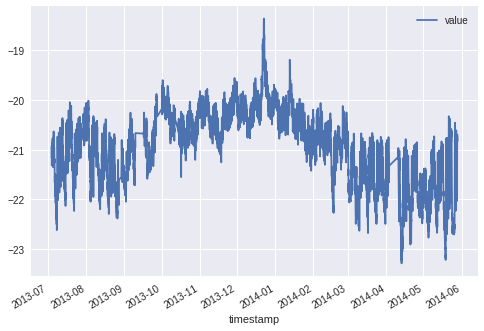

In [5]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

# ****************feature engineering*******************

#the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

# print(df.head())

a = df.loc[df['categories'] == 0, 'value'] #weekend day 
b = df.loc[df['categories'] == 1, 'value'] #weekend night
c = df.loc[df['categories'] == 2, 'value'] #weekday day
d = df.loc[df['categories'] == 3, 'value'] #weekday night

# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

# fig, ax = plt.subplots()
# a_heights, a_bins = np.histogram(a)
# b_heights, b_bins = np.histogram(b, bins=a_bins)
# c_heights, c_bins = np.histogram(c, bins=a_bins)
# d_heights, d_bins = np.histogram(d, bins=a_bins)

# # print(a_bins, "**", b_bins, "***", c_bins)
# # print(a_bins[1] - a_bins[0])

# width = (a_bins[1] - a_bins[0])/6
# # width = 1

# ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
# ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
# ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
# ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [0]:
df

In [0]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)


# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
print("x_train.shape",x_train.shape)
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

print(len(data_n))


# 60% - train set, 20% - validation set, 20% - test set

# datashff = data_n.sample(frac=1)  # randomly shuffles the ordering of filenames

# split_1 = int(0.6 * len(datashff)) -1
# split_2 = int(0.8 * len(datashff))
# traintmp = datashff[:split_1][0]
# validatetmp = datashff[split_1:split_2][0]
# testtmp = datashff[split_2:][0]


# traintmp, validatetmp, testtmp = np.split(data_n.sample(frac=1), [int(.6*len(data_n)), int(.8*len(data_n))])
# print(datashff.shape,"**", traintmp.shape, "**", validatetmp.shape, "**", testtmp.shape)


# pca_columns = list(('value', 'hours', 'DayOfTheWeek', 'WeekDay'))
# normal_pca_data = df[pca_columns]
# plt.matshow(normal_pca_data.corr()); #tells which pca are more correlated

x_train.shape (6215, 5)
7267


In [0]:
#this code block not used in data where data classification is not present

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)


def select_threshold(probs, test_data):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(test_data, predictions, average='samples')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon

    return best_f1, best_epsilon
  
mu, sigma = estimate_gaussian(traintmp)
pval = multivariate_gaussian(traintmp,mu,sigma)

p_cv = multivariate_gaussian(validatetmp,mu,sigma)
print(pval)
print(p_cv)
print("*******")
print(testtmp.shape)
# fscore, ep = select_threshold(p_cv,testtmp)
# print(fscore, ep, "and ")

# # selecting outlier datapoints
# outliers = np.asarray(np.where(pval < ep))

In [0]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
# print("xtrain.shape before", x_train.shape)
l =[]
l.append(x_train[:50])
xtemp_train = np.asarray(l)

print("****", xtemp_train.shape)

x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)

y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys


# Build the model
model = Sequential()

model.add(LSTM(units= 100,
    input_shape=(x_train.shape[1], 5),
#     output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='adagrad')
print('compilation time : {}'.format(time.time() - start))

# Train the model
epochs = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
#   epochs=30,
    epochs=30,
    validation_split=0.1)  #validation split 0.1, means 1 is to 9 split


# x_test

**** (1, 50, 5)
x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)
compilation time : 0.02153754234313965
Train on 5548 samples, validate on 617 samples
Epoch 1/30
5548/5548 [==============================] - 13s 2ms/step - loss: 0.8457 - val_loss: 1.2961
Epoch 2/30
5548/5548 [==============================] - 11s 2ms/step - loss: 0.7008 - val_loss: 0.5477
Epoch 3/30
5548/5548 [==============================] - 11s 2ms/step - loss: 0.2472 - val_loss: 0.2228
Epoch 4/30
5548/5548 [==============================] - 11s 2ms/step - loss: 0.0909 - val_loss: 0.1652
Epoch 5/30
5548/5548 [==============================] - 11s 2ms/step - loss: 0.0824 - val_loss: 0.1541
Epoch 6/30
5548/5548 [==============================] - 11s 2ms/step - loss: 0.0951 - val_loss: 0.1473
Epoch 7/30
5548/5548 [==============================] - 11s 2ms/step - loss: 0.0819 - val_loss: 0.1469
Epoch 8/30
5548/5548 [==============================] - 11s 2ms/step - loss: 0.1138 - val_loss: 0.1442


In [0]:
# x_test.shape
score = model.evaluate(x_test, y_test,
                            batch_size=100, verbose=1)
print('Test score:', score) #score is evaluation of loss function

1000/1000 [==============================] - 1s 626us/step
Test score: 0.1325460597872734


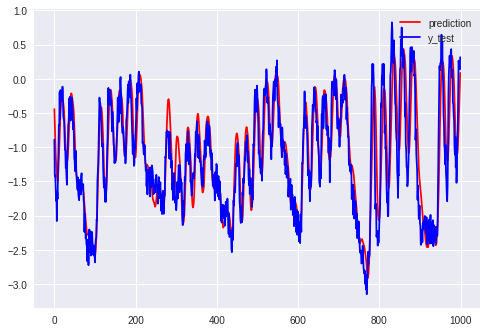

In [0]:
# save the model because the training is long (1h30) and we don't want to do it every time
"""
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")
"""

# load jsothresholdn and create model
"""
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
"""

# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]

# l =[]
# l.append(1)
# ytemp_train = np.asarray(l)
# x_test = xtemp_train
# y_test = ytemp_train

# # print(y_test.shape, "**", xtemp_train.shape)

p = loaded_model.predict(x_test)


# # predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    

fig1, axs1 = plt.subplots()
axs1.plot(p,color='red', label='prediction')
axs1.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper right')

plt.show()





In [0]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
print("diff leng", len(diff))
number_of_outliers = int(outliers_fraction*len(diff))
print("number of outliers", number_of_outliers)
threshold = diff.nlargest(number_of_outliers).min()
print("threshhold", threshold)
threshhold = diff.describe([.25,.50,.75,.80,.90, .95])['95%']
# data with anomaly label (test data part)
test = (diff >= threshhold).astype(int) # converts boolean to 1(true) or 0(false) 

# test = (diff >= ep).astype(int) # converts boolean to 1(true) or 0(false) 

# print("test", test)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
# df['anomaly27'] = test
print("anomaly value counts : \n",df['anomaly27'].value_counts())
#tells us there are 10 anomalies
type(diff.describe())

diff leng 1000
number of outliers 10
threshhold 1.0408787731876399
anomaly value counts : 
 0    7217
1      50
Name: anomaly27, dtype: int64


pandas.core.series.Series

In [0]:
filterdiff = diff[diff>=threshhold]
k =[y_test[x] for x in filterdiff.index]
k = pd.Series(k, index= filterdiff.index)

prediction accuracy 95.0 %


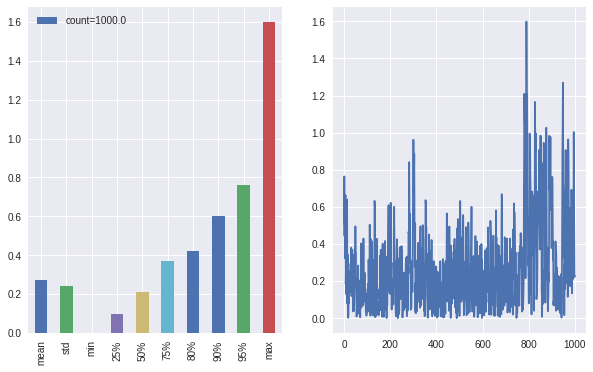

In [0]:
print("prediction accuracy {} %".format((len(diff) - len(filterdiff))/len(diff) *100))
fig, axs = plt.subplots(nrows = 1, ncols =2)

# d.loc['noofsamplesabovemean'] = ((diff>=diff.describe([.25,.50,.75,.80,.91])['mean']) == True).sum()
diff.describe([.25,.50,.75,.80,.90, .95]).drop('count').plot(ax =axs[0], kind='bar', label='count={}'.format(diff.describe([.25,.50,.75,.80,.91])['count']), legend =True)

diff.plot(ax = axs[1], label = 'difference graph', figsize = (10,6))

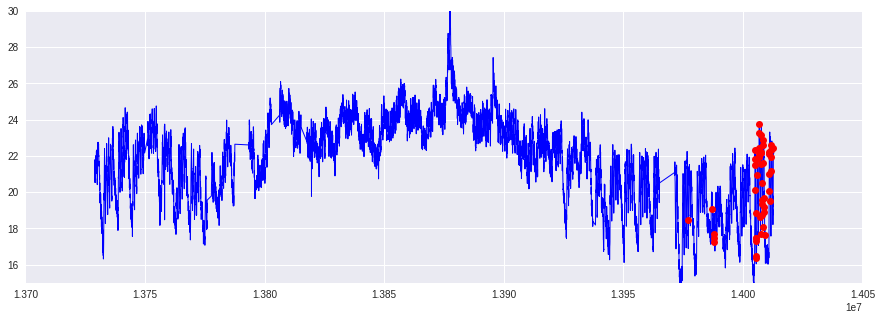

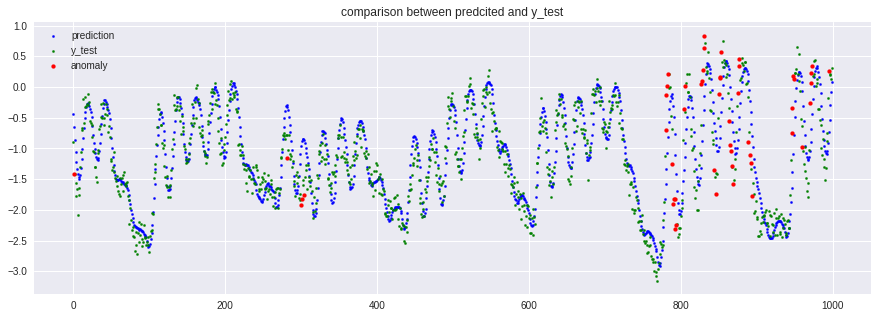

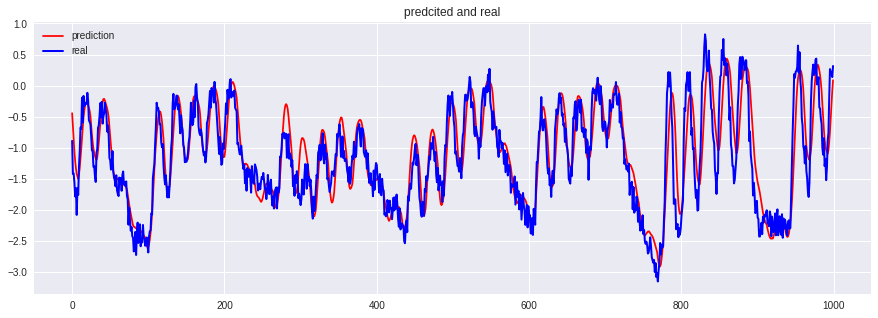

In [0]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize = (15,5))

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue', linewidth=1)
# ax.scatter(a['time_epoch'],a['value'], color='red', label='anomaly', s=50)
ax.plot(a['time_epoch'],a['value'], 'ro', label='anomaly' )
# fig = plt.figure(figsize = (20,5))
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
# plt.show() 

# plot the prediction and the reality (for the test data)
fig1, axs = plt.subplots(figsize = (15,5))
axs.scatter(x =list(range(0,1000)), y =p,color='blue', label='prediction', s=5)
axs.scatter(x = list(range(0,1000)), y=y_test,color='green', label='y_test', s=5)
axs.scatter(k.index.tolist(),k.values.tolist(), color='red', label='anomaly', s=15)
plt.legend(loc='upper left')
plt.title('comparison between predcited and y_test')
# plt.show()

fig2, axs2 = plt.subplots(figsize = (15,5))
axs2.plot(list(range(0,1000)), p,color='r', label='prediction')
axs2.plot(list(range(0,1000)), y_test,color='b', label='real', linewidth=2)
plt.legend(loc='upper left')
plt.title('predcited and real')
plt.show()


In [0]:
# ***************************ISOLATION FOREST***********************************************

In [0]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


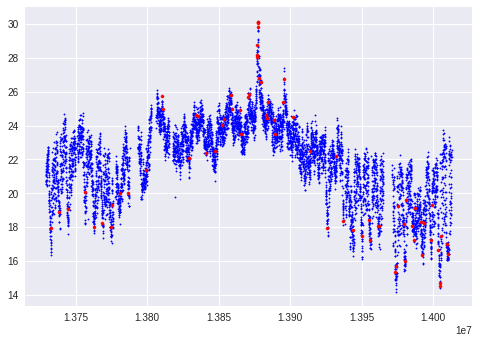

In [0]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.scatter(df['time_epoch'], df['value'], color='blue', s=2)
ax.scatter(a['time_epoch'],a['value'], color='red', s=10)
plt.show()